Anushna Prakash  
DATA 598 - Deep Learning  
January 28 2022  
# <center> Homework 3 </center>  
## Part I: The Effect of BatchNorm on a ConvNet  

First, download and preprocess the data.

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


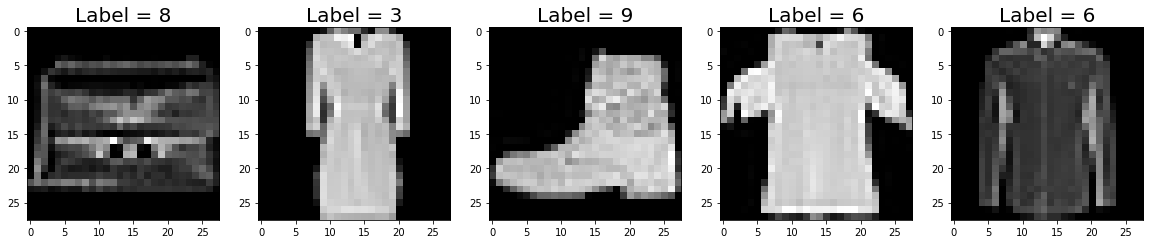

In [39]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import numpy as np

# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10)).long()
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
    
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

Create a Convolutional Neural Net with two convolutional layers:  
Input $(1, 28, 28) \rightarrow$ Convolution with $k=5$, `filters=16`, `padding=2` $\rightarrow$ ReLU $\rightarrow$ MaxPool with $k=2 \rightarrow$ Convolution with $k=5$, `filters=32`, `padding=2` $\rightarrow$ ReLU $\rightarrow$ MaxPool with $k=2 \rightarrow$ Linear output = 10

### Step 1: Figure out size `S` to flatten to  
This is for the `torch.nn.Linear` final step.  

In [45]:
image_size = 28
# 1 batch, 1 channel, 228x228 image
dummy = torch.randn(1, 1, image_size, image_size)

# Run dummy thru input layers
conv1 = torch.nn.Conv2d(
    in_channels=1, out_channels=16, kernel_size=5,
    padding=2, stride=1
)
out = conv1(dummy)
# 1 batch, 16 channels, image size, image size
print(out.shape)
relu = torch.nn.ReLU()
out = relu(out)
# 1 batch, 16 channels, image size, image size
print(out.shape)
pool = torch.nn.MaxPool2d(2)
out = pool(out)
# 1 batch, 16 channels, image size / kernel input size, image size / kernel input size
print(out.shape)

# Run thru second part
# Run dummy thru input layers
# Now has 16 input channels
conv2 = torch.nn.Conv2d(
    in_channels=16, out_channels=32, kernel_size=5,
    padding=2, stride=1
)
out = conv2(out)
# 1 batch, 32 channels, image size, image size
print(out.shape)
relu = torch.nn.ReLU()
out = relu(out)
# 1 batch, 32 channels, image size, image size
print(out.shape)
pool = torch.nn.MaxPool2d(2)
out = pool(out)
# 1 batch, 32 channels, image size / kernel input size, image size / kernel input size
print(out.shape)

# Now convert final out shape into 1 x 10

torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 14, 14])
torch.Size([1, 32, 14, 14])
torch.Size([1, 32, 14, 14])
torch.Size([1, 32, 7, 7])


In [41]:
import torch
class ConvNet(torch.nn.Module):
    """
    Defines a convolution neural net with 2 convolution layers
    Does not employ batch norming
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        # Final layer output is batch x channels x imagesize / 4 x imagesize / 4
        self.fully_connected_layer = torch.nn.Linear(7*7*32, num_classes)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28) # Resize, needs channel
        out = self.conv_ensemble_1(x) # Run thru layer 1
        out = self.conv_ensemble_2(out) # Run thru layer 2
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out

Create a Convolutional Neural Net that is the same as above, but has batch norm applied after each `MaxPool2d` layer.

In [42]:
class BatchNormConvNet(torch.nn.Module):
    """
    Defines a convolution neural net with 2 convolution layers
    Employ batch norming
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(num_features=16))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(num_features=32))
        self.fully_connected_layer = torch.nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28) # Resize, needs channel
        out = self.conv_ensemble_1(x) # Run thru layer 1
        out = self.conv_ensemble_2(out) # Run thru layer 2
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out

In [47]:
# Test
model = ConvNet(num_classes=10)
model2 = BatchNormConvNet(num_classes=10)

out = model(dummy)
out = model2(dummy)

In [37]:
X_train.shape

torch.Size([60000, 28, 28])

In [34]:
from torch.nn.functional import cross_entropy

def compute_objective(net, X, y):
    """ 
    Compute the multinomial logistic loss. 
    net is a module
    X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = net(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(net, X, y):
    """ 
    Compute the classification accuracy
    based on majority vote from augmented images.
    X of shape (n, d) and y of shape (n,)
    """
    score = net(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted

    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(net, verbose=False):
    """
    Compute loss & accuracy for train & test
    Returns values in tuple in the order:
    Train Loss, Train Accuracy, Test Loss, Test Accuracy
    """
    train_loss = compute_objective(net, X_train, y_train)
    test_loss = compute_objective(net, X_test, y_test)
    
    train_accuracy = compute_accuracy(net, X_train, y_train)
    test_accuracy = compute_accuracy(net, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

def minibatch_sgd_one_pass(net, X, y, learning_rate, batch_size, verbose=False):
    """
    Performs one pass of stochastic gradient descent.
    """
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(num_examples, size=(batch_size,))
        X_transformed = X[idxs]

        objective = compute_objective(net, X_transformed, y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        gradients = torch.autograd.grad(outputs=objective, inputs=net.parameters())
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(net.parameters(), gradients):
                w -= learning_rate * g
    return net